<a href="https://colab.research.google.com/github/datajcthemax/playdata/blob/main/day29_LSTM%EA%B3%BCCRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 29번째 이야기
- LSTM
- CRNN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터 생성
def generate_data(seq_length = 1000):
  time_steps = np.linspace(0, np.pi*8, seq_length)
  data = np.sin(time_steps)
  data = data.reshape(-1,1)
  return torch.tensor(data, dtype=torch.float32)

In [ ]:
dataset = generate_data()

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super().__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.h0=None
    self.c0=None

  def forward(self, x):
    self.x = x
    if self.h0 is None:
      self.param_init()
    self.h0, self.c0 = self.h0.detach(), self.c0.detach()
    out, (self.h0, self.c0) = self.lstm(self.x, (self.h0, self.c0)) # lstm은 h, c를 받는다
    out = self.fc(out[:,-1])
    return out
  def param_init(self):
    self.h0 = torch.zeros(self.num_layers, self.x.size(0), self.hidden_size)
    self.c0 = torch.zeros(self.num_layers, self.x.size(0), self.hidden_size)

In [ ]:
# hyper parameters
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 3
learning_rate = 1e-3
num_epochs = 100

In [ ]:
#dataset
dataset = generate_data()
train_data = dataset[:-200]
test_data = dataset[200:]

In [ ]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

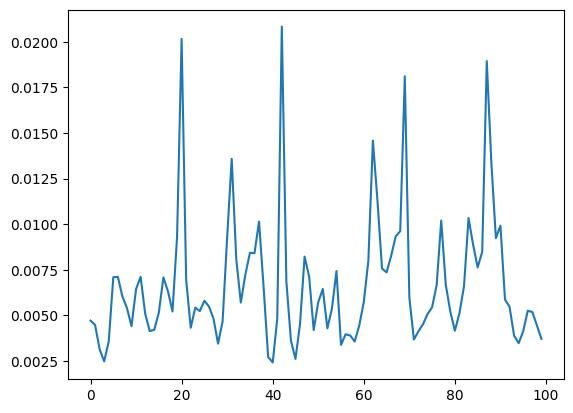

In [ ]:
from tqdm.auto import tqdm
import numpy as np
losses = []

for epoch in tqdm(range(num_epochs)):
  tmp_losses=[]
  # check
  for i in range(train_data.shape[0]):
    x = train_data[i:i+1].unsqueeze(0)
    y = train_data[i+1:i+2].unsqueeze(0)
    output = model(x)
    loss = criterion(output, y)
    optimizer.zero_grad()
    tmp_losses.append(loss.item())
    loss.backward()
    optimizer.step()    
  losses.append(np.array(tmp_losses[:-1]).mean())
plt.plot(losses)
plt.show()

# lstm의 특징에 맞는 코드가 빠졌습니다. 무엇일까요?
- 시계열 모델의 차별적인 부분
- 효과적으로 반영하려면 코드를 어떻게 손봐야 될까요

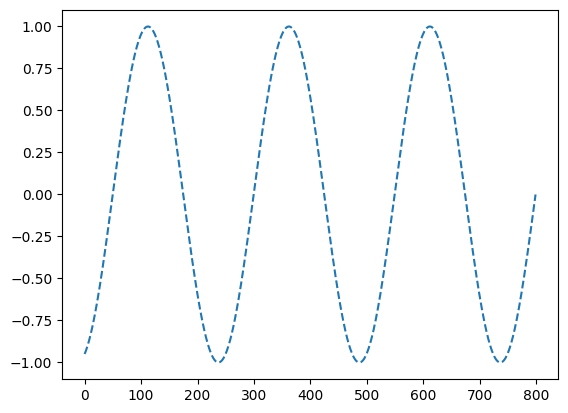

In [ ]:
plt.plot(test_data, '--')

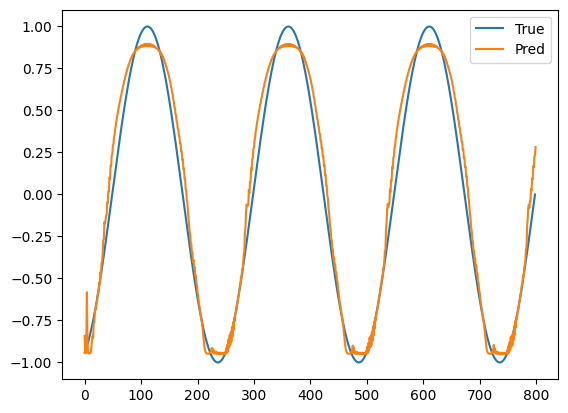

In [ ]:
model.eval() # cf) torch.no_grad
predicted = []
for i in range(test_data.shape[0]):
    x = test_data[i:i+1].unsqueeze(0)
    y = test_data[i+1:i+2].unsqueeze(0)
    output = model(x)
    loss = criterion(output, y)
    predicted.append(output.item())
# 결과 시각화
plt.plot(test_data[1:].numpy(), label='True')
plt.plot(np.array(predicted), label='Pred')
plt.legend()
plt.show()

# 딥러닝 정리
- ANN
- DNN
- CNN
- ResNet
- Transfer Learning
- Gan
- cGan
- RNN
- GRU
- LSTM
- CRNN

# 실습
- Finance DataReader로 주식 데이터 해보기
- imdb 자연어 데이터셋으로 모델 구성해 보기(긍정, 부정 평가)

In [ ]:
import tensorflow as tf

In [ ]:
vocab_size = 10000
max_len = 500
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

In [ ]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [ ]:
class LSTM_IMDB(nn.Module):
  def __init__(self, hidden_size, num_layers, output_size):
    super().__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    word_idx = 10000
    vector_len = 100
    self.emb = nn.Embedding(word_idx, vector_len)
    self.lstm = nn.LSTM(vector_len, hidden_size, num_layers)
    self.fc = nn.Sequential(nn.Linear(hidden_size, output_size),
                            nn.Dropout(0.2), 
                            nn.Sigmoid())
    

  def forward(self, x, h0, c0):    
    out, (h0, c0) = self.lstm(self.emb(x), (h0, c0)) # lstm은 h, c를 받는다
    out = self.fc(out[:,-1])    
    return out,h0, c0

In [ ]:
len(X_train[0])

218

In [ ]:
input_size = 100
hidden_size=128; num_layers=1; output_size=1;
model = LSTM_IMDB(hidden_size, num_layers, output_size)
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm.auto import tqdm
import numpy as np
losses = []

for epoch in tqdm(range(num_epochs)):
  tmp_losses=[]
  h0 = torch.zeros(num_layers, 1, hidden_size)
  c0 = torch.zeros(num_layers, 1, hidden_size)
  # check
  for x_t, y in zip(X_train, y_train):    
    for x in x_t:
      output, h0, c0 = model(torch.tensor(x).unsqueeze(0).unsqueeze(0), h0, c0)
    loss = criterion(output, torch.tensor(y).unsqueeze(0).unsqueeze(0).float())
    #h0, c0 = h0.detach(), c0.detach()
    optimizer.zero_grad()
    tmp_losses.append(loss.item())
    loss.backward()
    optimizer.step()    
  losses.append(np.array(tmp_losses[:-1]).mean())
plt.plot(losses)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored